In [84]:
# TO DO:
# call from csv for specific pokemon + stats - CHECK
# call from csv for specific moves - CHECK
# Physical Special split: CHECK
# Typing for Type modifier
# debug damage calculation!!!
# list all EVs combo that match lowest total EVs: CHECK
# add 0 EVs: CHECK
# Ensure total EVs don't exceed 508 - CHECK (hard coded in)
# add print results for if it survives all combo and for no combos

from itertools import product
import numpy as np
import csv
import math
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Typing import effectiveness

# Input the path to the CSV file
stats_csv_path = "C:/Users/geekv/Pokemon-Attack-Survival-Calculator/pokemon_stats.csv"
moves_csv_path = "C:/Users/geekv/Pokemon-Attack-Survival-Calculator/moves.csv"
# Note: All Z-Moves and Max/G-Max Moves are catorgized a physical by default

pokemon_info = {}
move_info = {}
# Open the CSV file
with open(stats_csv_path, 'r') as csvfile:
    # Create a CSV reader object
    csv_reader = csv.reader(csvfile)

    # Skip the header row
    next(csv_reader)

    for row in csv_reader:
            # Extract relevant information from the rows
            pokemon_name = row[1]
            form = row[2] if row[2] else "default"  # Use "default" if form is empty
            type1 = row[3]
            type2 = row[4]
            base_hp = int(row[5])
            base_attack = int(row[6])
            base_defense = int(row[7])
            base_special_attack = int(row[8])
            base_special_defense = int(row[9])
            base_speed = int(row[10])
            legal = int(row[11])  # 0 for illegal and 1 for legal

            # # Create a tuple of base stats and typing
            # base_stats = (base_hp, base_attack, base_defense, base_special_attack, base_special_defense, base_speed)
            # typing = (type1, type2)

            # Create a dictionary entry for the Pokémon
            key = (pokemon_name, form)
            pokemon_info[key] = {
                "base_stats": (base_hp, base_attack, base_defense, base_special_attack, base_special_defense, base_speed),
                "typing": (type1, type2),
                "legal": legal
            }

# Read the CSV file
with open(moves_csv_path, 'r') as csvfile:
    # Create a CSV reader object
    csv_reader = csv.reader(csvfile)

    # Skip the header row
    next(csv_reader)

    # Populate the move_info dictionary
    for row in csv_reader:
        move_name = row[1].strip()
        move_type = row[2].strip()
        move_damage_type = row[3].strip()
        base_power = int(row[5])

        # # Debug: Print each move being added
        # print(f"Adding move: {move_name}, Type: {move_type}, Attack Type: {move_attack_type}, Base Power: {base_power}")

        # Create a dictionary entry for the move
        move_info[move_name] = {
            "move_type": move_type,
            "damage_type": move_damage_type,
            "base_power": base_power,
        }

# Define a function to get Pokémon information for a given name and form
def get_pokemon_info(pokemon_name, form="default"):
    info = pokemon_info.get((pokemon_name, form), None)
    if info:
        return info["base_stats"], info["typing"]
    return None, None

# Define a function to get move information by name
def get_move_info(move_name):
    info = move_info.get(move_name, None)
    if info:
        return info["move_type"], info["damage_type"], info["base_power"]
    return None, None, None

# Define the Pokémon names and forms for attacker and defender
attacker_pokemon = "Iron Hands"
attacker_form = "default"
defender_pokemon = "Terapagos"
defender_form = "Stellar Form"

# Get the base stats and typing for the attacker and defender
atk_base, atk_typing = get_pokemon_info(attacker_pokemon, attacker_form)
def_base, def_typing = get_pokemon_info(defender_pokemon, defender_form)

# Print the results
print(f"Attacker: {attacker_pokemon} ({attacker_form}): {atk_typing}, {atk_base}")
print(f"Attacker: {defender_pokemon} ({defender_form}): {def_typing}, {def_base}")

# Define nature effects
natures = {
    'Adamant': (1.0, 1.1, 1.0, 0.9, 1.0, 1.0),
    'Bashful': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0), #Neutral
    'Bold': (1.0, 0.9, 1.1, 1.0, 1.0, 1.0),
    'Brave': (1.0, 1.1, 1.0, 1.0, 1.0, 0.9),
    'Calm': (1.0, 0.9, 1.0, 1.0, 1.1, 1.0),
    'Careful': (1.0, 1.0, 1.0, 0.9, 1.1, 1.0),
    'Docile': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0),  # Neutral
    'Gentle': (1.0, 1.0, 0.9, 1.0, 1.1, 1.0),
    'Hardy': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0),  # Neutral
    'Hasty': (1.0, 1.0, 0.9, 1.0, 1.0, 1.1),
    'Impish': (1.0, 1.0, 1.1, 0.9, 1.0, 1.0),
    'Jolly': (1.0, 1.0, 1.0, 0.9, 1.0, 1.1),
    'Lax': (1.0, 1.0, 1.1, 1.0, 0.9, 1.0),
    'Lonely': (1.0, 1.1, 0.9, 1.0, 1.0, 1.0),
    'Mild': (1.0, 1.0, 0.9, 1.1, 1.0, 1.0),
    'Modest': (1.0, 0.9, 1.0, 1.1, 1.0, 1.0),
    'Naive': (1.0, 1.0, 1.0, 1.0, 0.9, 1.1),
    'Naughty': (1.0, 1.1, 1.0, 1.0, 0.9, 1.0),
    'Quiet': (1.0, 1.0, 1.0, 1.1, 1.0, 0.9),
    'Quirky': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0),  # Neutral
    'Rash': (1.0, 1.0, 1.0, 1.1, 0.9, 1.0),
    'Relaxed': (1.0, 1.0, 1.1, 1.0, 1.0, 0.9),
    'Sassy': (1.0, 1.0, 1.0, 1.0, 1.1, 0.9),
    'Serious': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0),  # Neutral
    'Timid': (1.0, 0.9, 1.0, 1.0, 1.0, 1.1)
}

stages = {'-6': 2/8,
          '-5': 2/7,
          '-4': 2/6,
          '-3': 2/5,
          '-2': 2/4,
          '-1': 2/3,
          '0': 2/2,
          '1': 3/2,
          '2': 4/2,
          '3': 5/2,
          '4': 6/2,
          '5': 7/2,
          '6': 8/2}

# damage_types = {"Physical", "Special"}

terrains = {"Electric", "Psychic", "Grassy", "Misty"}
weather = {"Rain", "Sun", "Sand", "Snow"}

# Apply nature
def apply_nature(stats, nature):
    nature_modifiers = natures[nature]
    return tuple(math.floor(stat * nature_mod) for stat, nature_mod in zip(stats, nature_modifiers))

# Apply Threshold
def all_rolls_threshold(result):
    if result["Max Roll"] < 100:
        return result
    else:
        return None

def fifteensixteen_rolls_thresold(result):
    if result["Precentage Rolls"][-2] < 100 and result["Precentage Rolls"][-1] > 100:
        return result
    else:
        return None

IV = 31
level = 50
atk_nature = 'Adamant'
def_nature = 'Modest'
move_name = "Close Combat"
attacking_move = get_move_info(move_name)
attack_type, damage_type, base_power = attacking_move
Spread = 'False'
Crit = 'False'
Type = 2.0
stage_modifer = stages['0']
threshold = fifteensixteen_rolls_thresold

print(f"Move: {move_name}")
print(f"Move Type: {attack_type}")
print(f"Damage Type: {damage_type}")
print(f"Base Power: {base_power}")

# Calculate stats
def calculate_stats(base, EV, nature):
    stats = []
    for i in range(6):
        if i == 0:  # HP
            stat = math.floor(((2 * base[i] + IV + math.floor(EV[i] / 4)) * level) / 100) + level + 10
        else:
            stat = math.floor(((2 * base[i] + IV + math.floor(EV[i] / 4)) * level) / 100) + 5
        stats.append(stat)
    return apply_nature(stats, nature)

# atk_pokemon_stats = calculate_stats(atk_base, atk_EV, atk_nature)
# def_pokemon_stats = calculate_stats(def_base, def_EV, def_nature)

# print("Attacker Stats:", atk_pokemon_stats)
# print("Defender Stats:", def_pokemon_stats)

# Custom rounding method (round down at 0.5)
def custom_round(x):
    """Custom rounding method to round down at 0.5"""
    return int(x + 0.5) if x - int(x) >= 0.5 else int(x)

# Calculate damage
def damage_calc(level, base_power, atk_pokemon_stats, def_pokemon_stats):
    # Calculate the intermediate values, rounding each multiplication to the nearest integer
    # Physical Damage
    if damage_type == "Physical":
        damage = (((2 * level )/ 5 + 2) * base_power * ((calculate_stats(atk_base, atk_EV, atk_nature)[1]*stage_modifer) / calculate_stats(def_base, def_EV, def_nature)[2]) / 50 + 2)
    # Special Damage    
    else:
        damage = (((2 * level )/ 5 + 2) * base_power * ((calculate_stats(atk_base, atk_EV, atk_nature)[3]*stage_modifer) / calculate_stats(def_base, def_EV, def_nature)[4]) / 50 + 2)
    return damage

# Calculate spread modifier
def spread_modifer(level, base_power, atk_pokemon_stats, def_pokemon_stats):
    damage = math.floor(damage_calc(level, base_power, atk_pokemon_stats, def_pokemon_stats))
    if Spread == 'True':
        spread_modifer = 0.75
    else:
        spread_modifer = 1
    return damage * spread_modifer

# Calculate crit modifier
def crit_modifer(level, base_power, atk_pokemon_stats, def_pokemon_stats):
    damage = math.floor(spread_modifer(level, base_power, atk_pokemon_stats, def_pokemon_stats))
    if Crit == 'True':
        crit_modifer = 1.5
    else:
        crit_modifer = 1
    return damage * crit_modifer

# Iterate through all possible EV combinations for attacker
# Define a function to handle the different step sizes
def ev_range(start, stop, initial_step, final_step, switch_point):
    value = start
    while value < stop:
        yield value
        if value < switch_point:
            value += initial_step
        else:
            value += final_step

results = []
# step = 8  # Change this to the step value you desire (e.g., 4, 8, 12, etc.)

# Iterate through all possible EV combinations for attacker
for hp_evs in ev_range(0, 256, 4, 8, 4):
    for def_evs in ev_range(0, 256, 4, 8, 4):
        # Physical EVs 
        if damage_type == "Physical":
            atk_EV = (4, 252, 0, 0, 0, 252)
            def_EV = (hp_evs, 0, def_evs, 0, 0, 0)
        # Special EVs
        else:
            atk_EV = (4, 0, 0, 252, 0, 252)
            def_EV = (hp_evs, 0, 0, 0, def_evs, 0)

        # Calculate stats for attacking Pokémon
        atk_pokemon_stats = calculate_stats(atk_base, atk_EV, atk_nature)

        # Calculate stats for defending Pokémon
        def_pokemon_stats = calculate_stats(def_base, def_EV, def_nature)

        #Random Modifer
        damage_rolls = []
        for i in range(85, 101):  # Multiply by 0.85 to 1, inclusive
            multiplier = i / 100  # Convert the range to a float multiplier
            # Physical Damage
            if damage_type == "Physical":
                damage = math.floor(crit_modifer(level, base_power, atk_pokemon_stats[1], def_pokemon_stats[2]) * multiplier)
            # Special Damage
            else:
                damage = math.floor(crit_modifer(level, base_power, atk_pokemon_stats[3], def_pokemon_stats[4]) * multiplier)
            damage_rolls.append(damage)

        # Apply STAB modifier rounding
        if attack_type == atk_typing[0] or (atk_typing[1] and attack_type == atk_typing[1]):
            STAB_modifier = 1.5
        else:
            STAB_modifier = 1
        damage_rolls = [math.floor(damage * STAB_modifier) for damage in damage_rolls]

        # Apply Type modifier rounding
        damage_rolls = [math.floor(damage * Type) for damage in damage_rolls]

        #Find min and max damage rolls
        Min_roll = min(damage_rolls)
        Max_roll = max(damage_rolls)

        # print(atk_EV[1], str(atk_nature), "Urshifu (Single Strike) Wicked Blow vs.",def_EV[0],"HP /",def_EV[2], "Def", str(def_nature), "Flutter Mane on a critical hit:",damage_rolls[0],"-",damage_rolls[-1], "(",round(Min_roll/calculate_stats(def_base, def_EV, def_nature)[0] * 100, 1),"% -",round(Max_roll/calculate_stats(def_base, def_EV, def_nature)[0] * 100, 1),"%)")
        # print(damage_rolls)
        # print("Total EVs:", (hp_evs + def_evs))
        
        percentage_damage_rolls = []
        percentage_damage_rolls_results = [round(precentage_rolls/def_pokemon_stats[0] * 100, 1) for precentage_rolls in damage_rolls]
        percentage_damage_rolls.append(percentage_damage_rolls_results)

        result = {"HP EVs": hp_evs, 
                  "Def EVs": def_evs,"Total EVs": (hp_evs + def_evs), "Damage Rolls": damage_rolls, 
                  "Precentage Rolls":percentage_damage_rolls_results, "Max Roll": round(Max_roll/calculate_stats(def_base, def_EV, def_nature)[0] * 100, 1)}
        results.append(result)
        # print(results)

filtered_results = list(filter(threshold, results))

if not filtered_results:
    for key, value in results[0].items():  # Use results[0] instead of result
        print(f"{key}: {value}")
else:
    # Find the result with the lowest "Total_EVs"
    lowest_total_evs_result = min(filtered_results, key=lambda x: x["Total EVs"])

    # Extract the minimum "Total_EVs" value
    min_total_evs = lowest_total_evs_result["Total EVs"]

    # Filter all results that have the same "Total_EVs" value
    matching_results = [result for result in filtered_results if result["Total EVs"] == min_total_evs]

    # Print the matching results
    # if matching_results:
    for result in matching_results:
        for key, value in result.items():
            print(f"{key}: {value}")

Attacker: Iron Hands (default): ('Fighting', 'Electric'), (154, 140, 108, 50, 68, 50)
Attacker: Terapagos (Stellar Form): ('Normal', ''), (160, 105, 110, 130, 110, 85)
Move: Close Combat
Move Type: Fighting
Damage Type: Physical
Base Power: 120
HP EVs: 0
Def EVs: 100
Total EVs: 100
Damage Rolls: [200, 200, 204, 206, 210, 212, 212, 216, 218, 222, 224, 224, 228, 230, 234, 236]
Precentage Rolls: [85.1, 85.1, 86.8, 87.7, 89.4, 90.2, 90.2, 91.9, 92.8, 94.5, 95.3, 95.3, 97.0, 97.9, 99.6, 100.4]
Max Roll: 100.4


In [3]:
atk_typing[0]

'Fighting'

In [9]:
print("\n".join(map(str, results)))


{'HP EVs': 0, 'Def EVs': 0, 'Total EVs': 0, 'Damage Rolls': [218, 222, 224, 228, 230, 234, 236, 240, 240, 242, 246, 248, 252, 254, 258, 260], 'Precentage Rolls': [92.8, 94.5, 95.3, 97.0, 97.9, 99.6, 100.4, 102.1, 102.1, 103.0, 104.7, 105.5, 107.2, 108.1, 109.8, 110.6], 'Max Roll': 110.6}
{'HP EVs': 0, 'Def EVs': 4, 'Total EVs': 4, 'Damage Rolls': [218, 222, 224, 228, 230, 234, 236, 240, 240, 242, 246, 248, 252, 254, 258, 260], 'Precentage Rolls': [92.8, 94.5, 95.3, 97.0, 97.9, 99.6, 100.4, 102.1, 102.1, 103.0, 104.7, 105.5, 107.2, 108.1, 109.8, 110.6], 'Max Roll': 110.6}
{'HP EVs': 0, 'Def EVs': 12, 'Total EVs': 12, 'Damage Rolls': [218, 218, 222, 224, 228, 230, 234, 236, 236, 240, 242, 246, 248, 252, 254, 258], 'Precentage Rolls': [92.8, 92.8, 94.5, 95.3, 97.0, 97.9, 99.6, 100.4, 100.4, 102.1, 103.0, 104.7, 105.5, 107.2, 108.1, 109.8], 'Max Roll': 109.8}
{'HP EVs': 0, 'Def EVs': 20, 'Total EVs': 20, 'Damage Rolls': [216, 218, 218, 222, 224, 228, 230, 234, 236, 236, 240, 242, 246, 248,

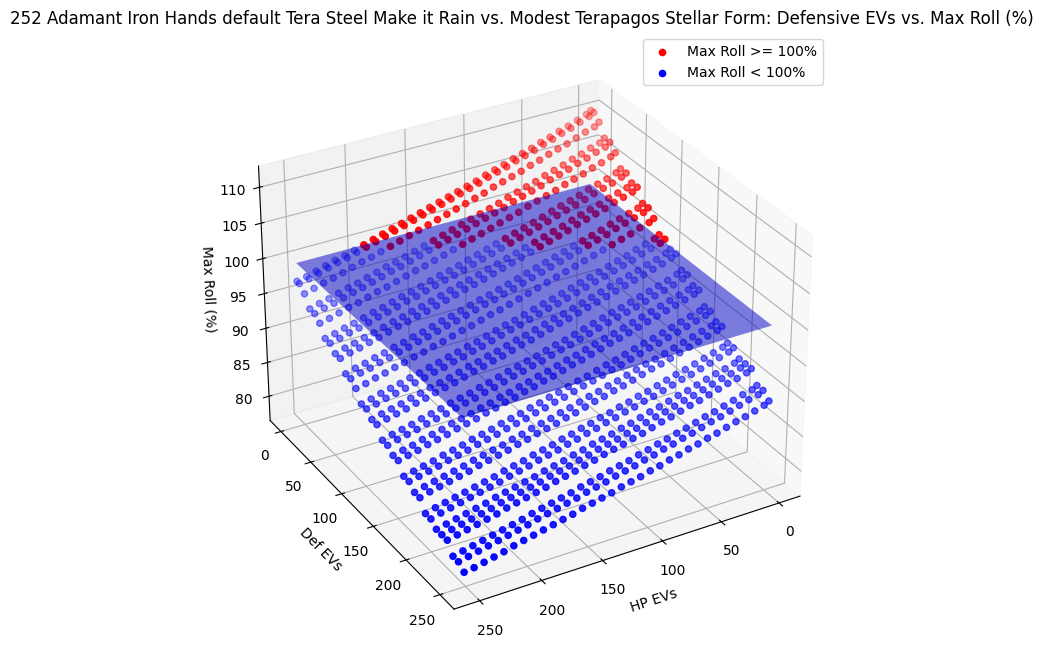

In [10]:
# 3D Plot inillustrating defensive EVs vs. damage rolls
# Extract data
hp_evs = [result["HP EVs"] for result in results]
def_evs = [result["Def EVs"] for result in results]
max_rolls = [result["Max Roll"] for result in results]

# Separate the points based on the condition Max Roll < 100
highlight_hp_evs = [hp_evs[i] for i in range(len(max_rolls)) if max_rolls[i] < 100]
highlight_def_evs = [def_evs[i] for i in range(len(max_rolls)) if max_rolls[i] < 100]
highlight_max_rolls = [max_rolls[i] for i in range(len(max_rolls)) if max_rolls[i] < 100]

normal_hp_evs = [hp_evs[i] for i in range(len(max_rolls)) if max_rolls[i] >= 100]
normal_def_evs = [def_evs[i] for i in range(len(max_rolls)) if max_rolls[i] >= 100]
normal_max_rolls = [max_rolls[i] for i in range(len(max_rolls)) if max_rolls[i] >= 100]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot normal points

ax.scatter(normal_hp_evs, normal_def_evs, normal_max_rolls, c='r', marker='o', label='Max Roll >= 100%')

# Plot highlighted points
ax.scatter(highlight_hp_evs, highlight_def_evs, highlight_max_rolls, c='b', marker='o', label='Max Roll < 100%')

# Set labels
ax.set_xlabel('HP EVs')
ax.set_ylabel('Def EVs')
ax.set_zlabel('Max Roll (%)')

# Set the viewing angle (elevation, azimuth)
ax.view_init(elev=30, azim=60)

# Create a grid for the plane
x = np.linspace(min(hp_evs), max(hp_evs), 100)
y = np.linspace(min(def_evs), max(def_evs), 100)
x, y = np.meshgrid(x, y)
z = np.full_like(x, 100)  # Adjust the Z value for the plane as needed

# Plot the plane
ax.plot_surface(x, y, z, alpha=0.5, rstride=100, cstride=100, color='blue')

# Set the title
title = f"{atk_EV[1]} {atk_nature} {str(attacker_pokemon)} {str(attacker_form)} Tera Steel Make it Rain vs. {def_nature} {str(defender_pokemon)} {str(defender_form)}: Defensive EVs vs. Max Roll (%)"
ax.set_title(title)

# Add legend
ax.legend()

# Show plot
plt.show()